## Fine-Tuning DistilBert Poem Sentiment

# [Link to my Youtube Video Explaining this whole Notebook](https://www.youtube.com/watch?v=zcW2HouIIQg&list=PLxqBkZuBynVQEvXfJpq3smfuKq3AiNW-N&index=5)

[![Imgur](https://imgur.com/bzhhXLq.png)](https://www.youtube.com/watch?v=zcW2HouIIQg&list=PLxqBkZuBynVQEvXfJpq3smfuKq3AiNW-N&index=5)

## First What is BERT?

BERT stands for Bidirectional Encoder Representations from Transformers. The name itself gives us several clues to what BERT is all about.

BERT architecture consists of several Transformer encoders stacked together. Each Transformer encoder encapsulates two sub-layers: a self-attention layer and a feed-forward layer.

### There are two different BERT models:

- BERT base, which is a BERT model consists of 12 layers of Transformer encoder, 12 attention heads, 768 hidden size, and 110M parameters.

- BERT large, which is a BERT model consists of 24 layers of Transformer encoder,16 attention heads, 1024 hidden size, and 340 parameters.



BERT Input and Output
BERT model expects a sequence of tokens (words) as an input. In each sequence of tokens, there are two special tokens that BERT would expect as an input:

- [CLS]: This is the first token of every sequence, which stands for classification token.
- [SEP]: This is the token that makes BERT know which token belongs to which sequence. This special token is mainly important for a next sentence prediction task or question-answering task. If we only have one sequence, then this token will be appended to the end of the sequence.


It is also important to note that the maximum size of tokens that can be fed into BERT model is 512. If the tokens in a sequence are less than 512, we can use padding to fill the unused token slots with [PAD] token. If the tokens in a sequence are longer than 512, then we need to do a truncation.

And that’s all that BERT expects as input.

BERT model then will output an embedding vector of size 768 in each of the tokens. We can use these vectors as an input for different kinds of NLP applications, whether it is text classification, next sentence prediction, Named-Entity-Recognition (NER), or question-answering.


------------

**For a text classification task**, we focus our attention on the embedding vector output from the special [CLS] token. This means that we’re going to use the embedding vector of size 768 from [CLS] token as an input for our classifier, which then will output a vector of size the number of classes in our classification task.

-----------------------

![Imgur](https://imgur.com/NpeB9vb.png)

-------------------------

In [ ]:
# !pip install transformers wordcloud umap-learn plotly nltk nlp datasets

In [ ]:
import pandas as pd
import numpy as np
from transformers import pipeline
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
# import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nlp


import torch
import torch.nn.functional as F

In [ ]:
from datasets import load_dataset

ds_original_from_hf = load_dataset("poem_sentiment")

ds_original_from_hf

Using custom data configuration default
Reusing dataset poem_sentiment (/root/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 892
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 105
    })
    test: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 104
    })
})

In [ ]:
train_ds = ds_original_from_hf['train']
train_ds

Dataset({
    features: ['id', 'verse_text', 'label'],
    num_rows: 892
})

In [ ]:
label_names = ds_original_from_hf['train'].features['label'].names
label_names

['negative', 'positive', 'no_impact', 'mixed']

In [ ]:
print('Length of the Data', len(train_ds))

train_ds[0]

Length of the Data 892


{'id': 0,
 'label': 1,
 'verse_text': 'with pale blue berries. in these peaceful shades--'}

In [ ]:
train_ds.column_names

['id', 'verse_text', 'label']

In [ ]:
train_ds.features

{'id': Value(dtype='int32', id=None),
 'label': ClassLabel(num_classes=4, names=['negative', 'positive', 'no_impact', 'mixed'], id=None),
 'verse_text': Value(dtype='string', id=None)}

In [ ]:
train_ds[:2]

{'id': [0, 1],
 'label': [1, 2],
 'verse_text': ['with pale blue berries. in these peaceful shades--',
  'it flows so long as falls the rain,']}

In [ ]:
train_ds['verse_text'][:2]

['with pale blue berries. in these peaceful shades--',
 'it flows so long as falls the rain,']

In [ ]:
train = pd.DataFrame(ds_original_from_hf['train'])
train.head()

,id,verse_text,label
0,0,with pale blue berries. in these peaceful shad...,1
1,1,"it flows so long as falls the rain,",2
2,2,"and that is why, the lonesome day,",0
3,3,"when i peruse the conquered fame of heroes, an...",3
4,4,of inward strife for truth and liberty.,3


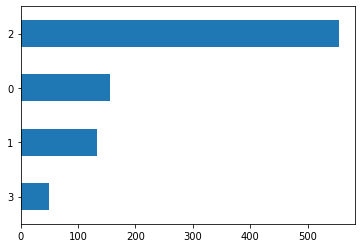

In [ ]:
train['label'].value_counts(ascending=True).plot.barh()
plt.show()

## Tokenize

In [ ]:
from transformers import AutoTokenizer

model_ckpt = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
#for inspecting the vocabulary size
print('tokenizer vocab size: ',tokenizer.vocab_size) 


#Model maximum context size
print('Model max length: ',tokenizer.model_max_length)


# features name - An attribute to know about is the names of the fields that the model expects in its forward pass:
print('Features name: ',tokenizer.model_input_names)

tokenizer vocab size:  30522
Model max length:  512
Features name:  ['input_ids', 'attention_mask']


In [ ]:
def tokenize(batch):
    return tokenizer(batch['verse_text'], padding=True, truncation=True)

In [ ]:
print(tokenize(ds_original_from_hf['train'][:2]))

{'input_ids': [[101, 2007, 5122, 2630, 22681, 1012, 1999, 2122, 9379, 13178, 1011, 1011, 102], [101, 2009, 6223, 2061, 2146, 2004, 4212, 1996, 4542, 1010, 102, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]}


![Imgur](https://imgur.com/f7CHg4R.png)

![Imgur](https://imgur.com/3RY8Gfl.png)

In [ ]:
ds_pretrained_features_encoded = ds_original_from_hf.map(tokenize, batched=True, batch_size=None)

print('Feature Names of Dataset ', ds_pretrained_features_encoded['train'].column_names)

Loading cached processed dataset at /root/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099/cache-68f0ec8fb06630d8.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099/cache-1816cab0d10ebee6.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099/cache-fa7357d3ccf35ba8.arrow


Feature Names of Dataset  ['id', 'verse_text', 'label', 'input_ids', 'attention_mask']


## Training a Text Classifier - DistilBERT

### Token Encoding > Token Embedding > Encoder Stack > Hidden states > Classification head > Predictions

## Using Pretrained Model - DistilBERT

In [ ]:
from transformers import AutoModel

model_ckpt = 'distilbert-base-uncased'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def get_hidden_state(batch):
    inputs = {k:v.to(device) for k, v in batch.items()
                if k in tokenizer.model_input_names }
    
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
        
    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy() }

ds_pretrained_features_encoded.set_format('torch', columns = ["input_ids", "attention_mask", "label"] )

pretrained_hidden_states = ds_pretrained_features_encoded.map(get_hidden_state, batched=True)

pretrained_hidden_states['train'].column_names

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

['id', 'verse_text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [ ]:
import numpy as np

X_train = np.array(pretrained_hidden_states["train"]["hidden_state"])
X_valid = np.array(pretrained_hidden_states['validation']["hidden_state"])

y_train = np.array(pretrained_hidden_states["train"]["label"])
y_valid = np.array(pretrained_hidden_states["validation"]["label"])
print(f'Xtrain_shape : {X_train.shape}, X_valid_shape: {X_valid.shape}')

Xtrain_shape : (892, 768), X_valid_shape: (105, 768)


In [ ]:
# in this data hidden state 768 dimensions and featured scale [0,1] interval like MinMaxScale
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_train_scaled = MinMaxScaler().fit_transform(X_train)

# initialize and fit UMAP
mapper = UMAP(n_components = 2, metric="cosine").fit(X_train_scaled)

# Create a Dataframe of 2D embeddings

df_embedded_from_hidden = pd.DataFrame(mapper.embedding_,columns=["X","Y"])

df_embedded_from_hidden["label"] = y_train

display(df_embedded_from_hidden.head())

,X,Y,label
0,14.721684,10.933453,1
1,10.480636,8.586606,2
2,13.384634,7.747568,0
3,10.268559,7.783114,3
4,13.069255,9.834933,3


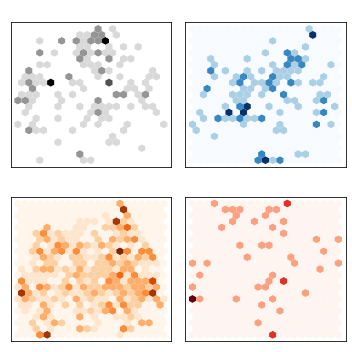

In [ ]:
fig,axes = plt.subplots(2, 2, figsize=(5,5))

#1D axises
axes = axes.flatten()
''' extracting all 3 axes using flatten, so now it will be a list like below
[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:>]
'''

#Color used
cmaps = ['Greys', "Blues", "Oranges", "Reds", "Purples", "Greens"]

#Labels name of ds_original_from_hf
labels = ds_original_from_hf["train"].features["label"].names

#separate
for i,(label, cmap) in enumerate(zip(labels, cmaps)):
    df_embedding_subplot = df_embedded_from_hidden.query(f"label == {i}")
    axes[i].hexbin(df_embedding_subplot["X"], df_embedding_subplot["Y"], cmap=cmap,
                  gridsize= 20, linewidths=(0,))
    axes[i].set_title(label, color='white')
    axes[i].set_xticks([]),axes[i].set_yticks([])
    
plt.tight_layout()
plt.show()

## Training a simple Logistic Classifier**

In [ ]:
from sklearn.linear_model import LogisticRegression
# Max iteration (3000)
lr_clf = LogisticRegression(max_iter = 3000)
lr_clf.fit(X_train, y_train)
print('Logistic Regression_Score',lr_clf.score(X_valid, y_valid))

Logistic Regression_Score 0.780952380952381


In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent')

dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_valid, y_valid))

0.6571428571428571


In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = len(ds_original_from_hf['train'].features['label'].names)

model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels ).to(device) )

from sklearn.metrics import accuracy_score, f1_score

def compute_metric(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average = 'weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1}


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifi

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 12

logging_steps = len(ds_pretrained_features_encoded['train']) // batch_size

model_name = f"{model_ckpt}-finetune-poem"

training_args = TrainingArguments(output_dir = model_name, 
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error"
                                  )

In [ ]:
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metric,
                  train_dataset = ds_pretrained_features_encoded['train'],
                  eval_dataset = ds_pretrained_features_encoded["validation"],
                  tokenizer = tokenizer
                  )
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.055400,0.830094,0.657143,0.521182
2,0.780100,0.664563,0.790476,0.748056


TrainOutput(global_step=150, training_loss=0.9161495939890544, metrics={'train_runtime': 10.1435, 'train_samples_per_second': 175.877, 'train_steps_per_second': 14.788, 'total_flos': 12924311538432.0, 'train_loss': 0.9161495939890544, 'epoch': 2.0})

In [ ]:
preds_output = trainer.predict(ds_pretrained_features_encoded['validation'])

In [ ]:
preds_output.metrics

{'test_accuracy': 0.7904761904761904,
 'test_f1': 0.7480555555555555,
 'test_loss': 0.6645627021789551,
 'test_runtime': 0.2719,
 'test_samples_per_second': 386.239,
 'test_steps_per_second': 33.106}

In [95]:
from torch.nn.functional import cross_entropy

def forward_pass_with_loss_and_label(batch):
    """
    This function performs a forward pass through the model, computes the loss and predicts labels.

    Args:
        batch (Dict[str, torch.Tensor]): Dictionary containing the model inputs and labels.

    Returns:
        Dict[str, Union[torch.Tensor, np.ndarray]]: Dictionary with the computed loss and predicted labels.
    """
    # Move the model inputs to the GPU (if available)
    # This is necessary because the model itself is likely on the GPU
    # Only model input names are included, other keys (e.g., 'labels') are ignored
    inputs = {k: v.to(device) for k, v in batch.items() 
              if k in tokenizer.model_input_names }

    # Ensures that gradients are not computed, saving memory
    with torch.no_grad():
        # Forward pass through the model
        output = model(**inputs)

        # Predict labels by selecting the argmax of the logits along the last dimension
        pred_label = torch.argmax(output.logits, axis=-1)

        # Compute the cross-entropy loss between the logits and true labels
        # reduction='none' ensures that we get a loss value for each sample, not the mean loss
        loss = cross_entropy(output.logits, batch['label'].to(device), reduction='none')

    # Returns the loss and predicted labels as numpy arrays
    # These are moved to the CPU first, because numpy cannot handle GPU tensors
    return {'loss': loss.cpu().numpy(), 
            'predicted_label': pred_label.cpu().numpy()}


In [96]:
#hide_output
# Convert our dataset back to PyTorch tensors
ds_pretrained_features_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
ds_pretrained_features_encoded["validation"] = ds_pretrained_features_encoded["validation"].map(
    forward_pass_with_loss_and_label, batched=True, batch_size=16)


  0%|          | 0/7 [00:00<?, ?ba/s]

In [101]:
def label_int2str(row):
    return ds_original_from_hf['train'].features['label'].int2str(row)

ds_pretrained_features_encoded.set_format("pandas")

cols = ['verse_text', "label", "predicted_label", "loss"]

df_test = ds_pretrained_features_encoded["validation"][:][cols]

df_test["label"] = df_test["label"].apply(label_int2str)

df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

df_test.sort_values('loss', ascending=False ).head(10)


,verse_text,label,predicted_label,loss
63,on us lift up the light,positive,no_impact,2.889908
6,"taking and giving radiance, and the slopes",positive,no_impact,2.548752
41,alone went the fair-armed gudrun to her flower...,positive,no_impact,2.542432
66,i kin eat in peace.,positive,no_impact,2.439461
73,willis sneered:,negative,no_impact,2.052364
52,"nor can express the love it knew,",negative,no_impact,2.046928
80,strong tarchon snatch’d and bore away his prize.,positive,no_impact,2.033585
22,"let fall on her a rose-leaf rain of dreams,",positive,no_impact,1.925899
5,"when the brow is cold as the marble stone,",negative,no_impact,1.862423
67,"in yonder green meadow, to memory dear,",positive,no_impact,1.789048


In [103]:
df_test.sort_values('loss', ascending=True ).head(10)

,verse_text,label,predicted_label,loss
54,"might, looking up, see dian dip",no_impact,no_impact,0.132735
74,"from the bed of minnehaha,",no_impact,no_impact,0.139521
39,"soon ez she gits out o' sight,",no_impact,no_impact,0.145044
45,"and i greet from far the ray,",no_impact,no_impact,0.147996
100,"said my companion, 'i will show you soon",no_impact,no_impact,0.154748
89,"""who's we?--some stockholders in boston?",no_impact,no_impact,0.156659
18,"ef 'twarn't for studyin' evenins, why, i never...",no_impact,no_impact,0.159213
31,did all of them bow downward towards that side,no_impact,no_impact,0.159555
28,"what though the claret circled well,",no_impact,no_impact,0.161425
90,and tell you in what greek and latin name,no_impact,no_impact,0.165941
